# Data Evaluation with NoisySignalIntegration.jl

## Example 1

This example shows the basic NSI evaluation workflow, see the docs [→ here](https://nluetts.github.io/NoisySignalIntegration.jl/dev/overview/#Workflow) and [→ here](https://nluetts.github.io/NoisySignalIntegration.jl/dev/guide/).

In [1]:
# Project activation and imports

import Pkg
Pkg.activate(".")

using DelimitedFiles
using NoisySignalIntegration
using Plots

# Set plotting backend and defaults
plotlyjs()
theme(:bright; label=nothing);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-15271866645667870073\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4634303021227986031\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-15271866645667870073\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Import the dataset (you can upload your own dataset and change the name of the loaded file here):

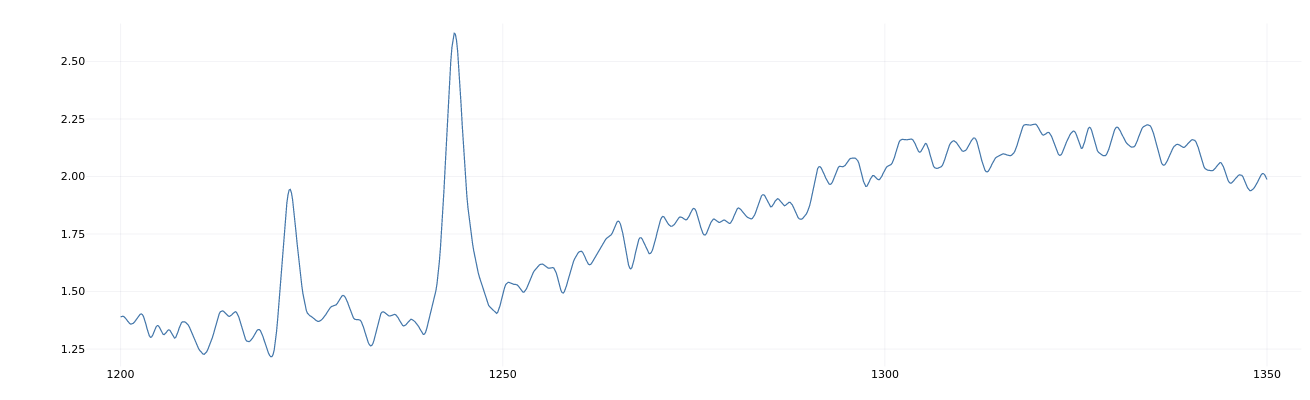

In [2]:
datafilename = "testdata-1.csv"
delimiter = ',' # verify that this is the right delimiter in case you work with your own data

dataset = let
    dat = readdlm(datafilename, delimiter)
    Curve(dat[:,1], dat[:,2])
end

plot(dataset)

Divide ([crop](https://nluetts.github.io/NoisySignalIntegration.jl/dev/API/#NoisySignalIntegration.crop)) into signal and noise:

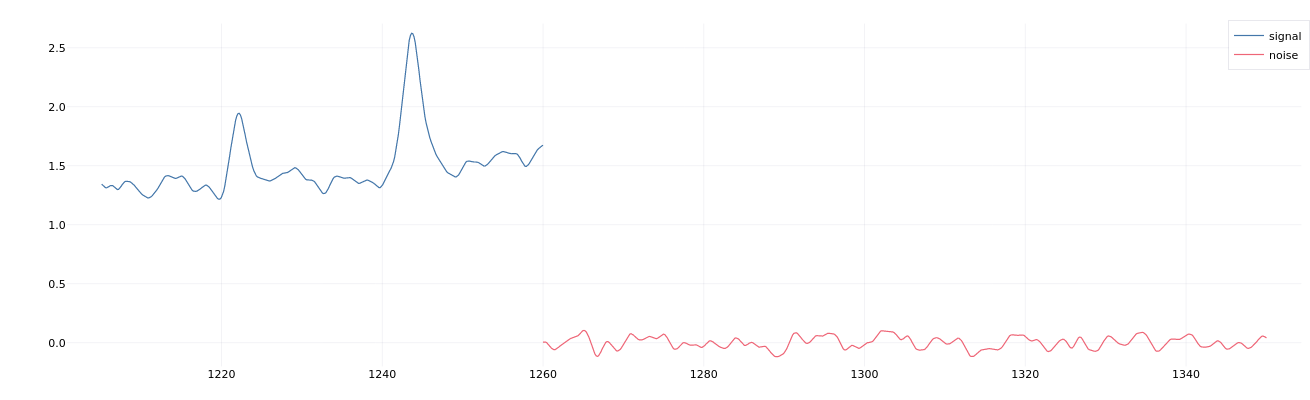

In [3]:
signal = crop(dataset, 1205, 1260)
# use the data from x = 1260 to 1350 as noise sample
# subtract 3rd order polynomial from noise sample
noisesample = NoiseSample(crop(dataset, 1260, 1350), 3)

plot(signal; label="signal")
plot!(noisesample; label="noise")

[Analyze noise sample](https://nluetts.github.io/NoisySignalIntegration.jl/dev/API/#Noise-analysis) and derive noise model:

In [4]:
noisemodel = fit_noise(noisesample)

MvGaussianNoiseModel(α = 0.050342765920317584, λ = 0.6861625720248022)


Plot generated noise vs. noise sample to verify validity of noise model (noise should look very similar in all plots):

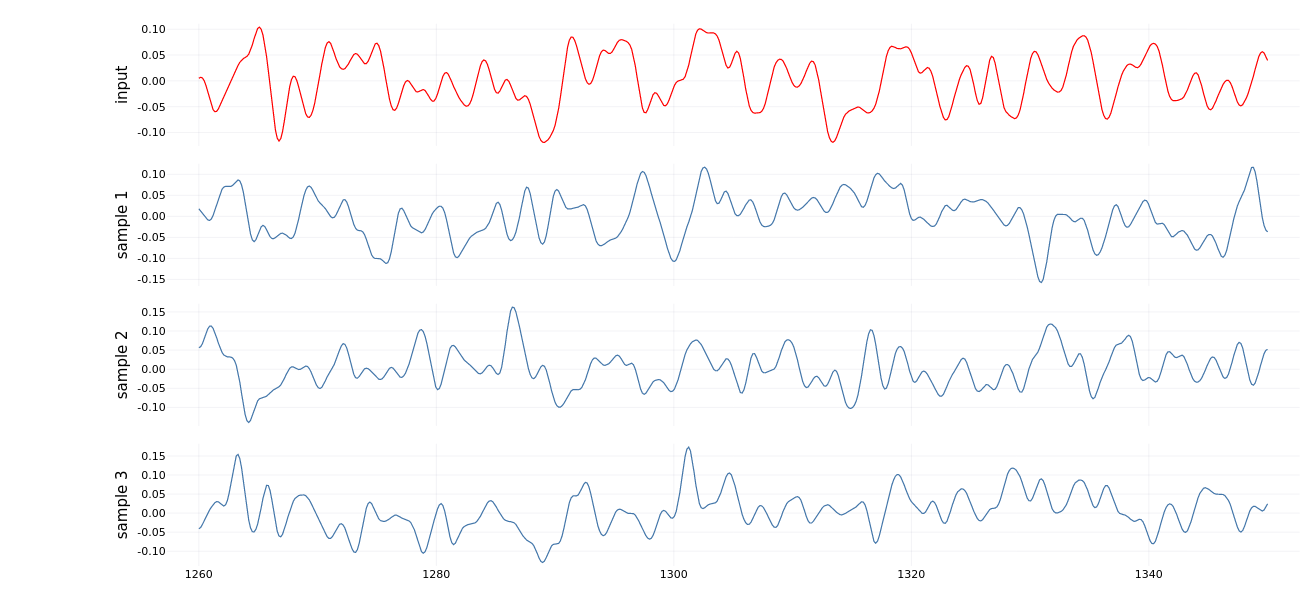

In [5]:
plot(noisesample, noisemodel)

[Prepare uncertain curve](https://nluetts.github.io/NoisySignalIntegration.jl/dev/guide/#Preparing-the-spectrum-for-integration):

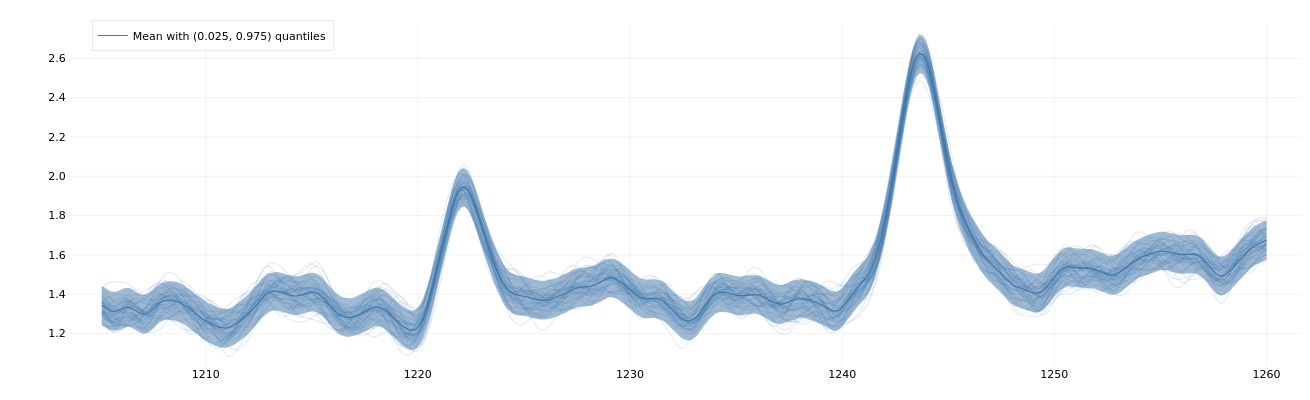

In [6]:
unc_signal = add_noise(signal, noisemodel)

plot(unc_signal; legend=:topleft)

[Define integration bounds](https://nluetts.github.io/NoisySignalIntegration.jl/dev/guide/#bounds_guide) (here assuming symmetric peaks):

In [7]:
leftbnd  = UncertainBound(1222.0, scale_shift_beta(2, 2, 4, 7), unc_signal)
rightbnd = UncertainBound(1243.0, scale_shift_beta(2, 2, 7, 10), unc_signal);

Visualize the integration bounds, either by [plotting some draws](https://nluetts.github.io/NoisySignalIntegration.jl/dev/guide/#plot_mc_draws) or generating a GIF with `NoisySignalIntegration.animate_draws()`:

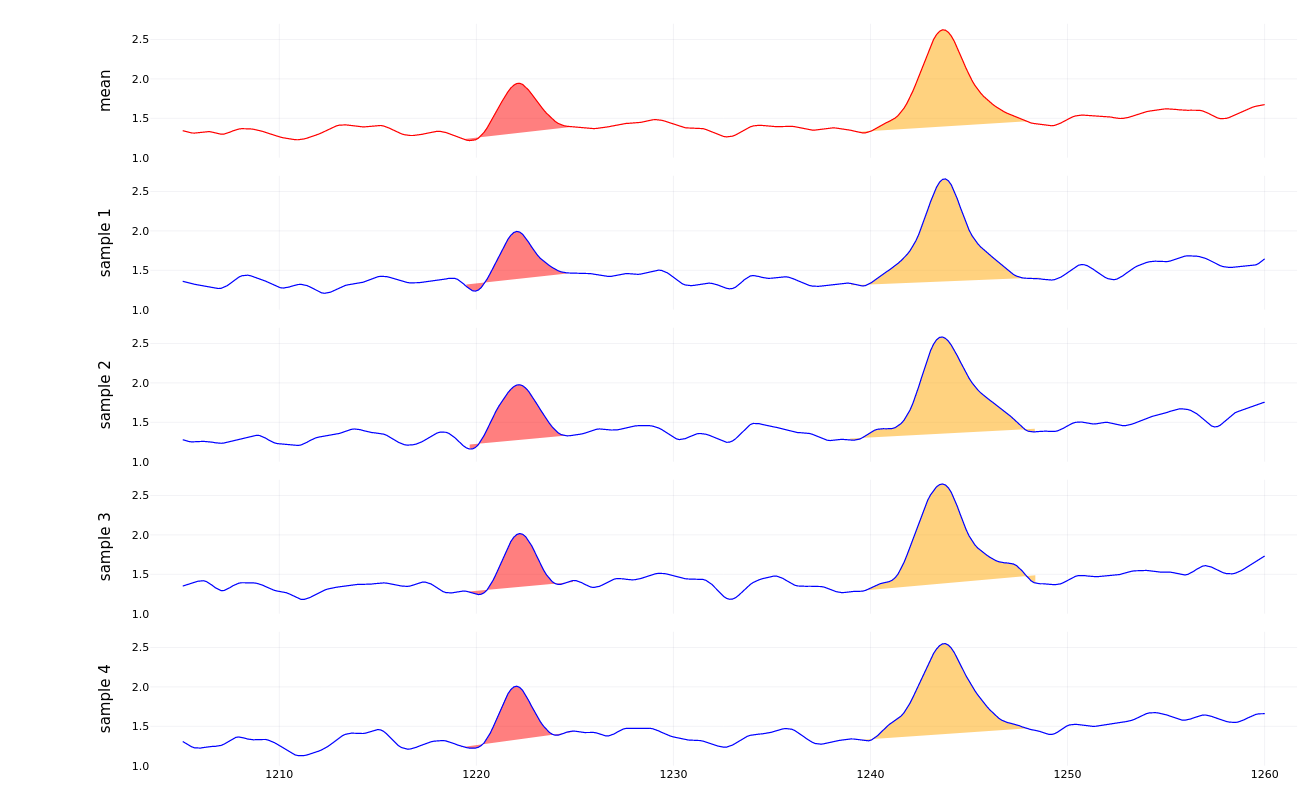

In [8]:
plot(unc_signal, [leftbnd, rightbnd]; local_baseline=true, draws=4, size=(400, 800), ylims=(1.0, 2.7))

┌ Info: Saved animation to 
│   fn = /tmp/jl_p9MGMA.gif
└ @ Plots /home/jovyan/.julia/packages/Plots/isZEW/src/animation.jl:104


Plots.AnimatedGif("/tmp/jl_p9MGMA.gif")
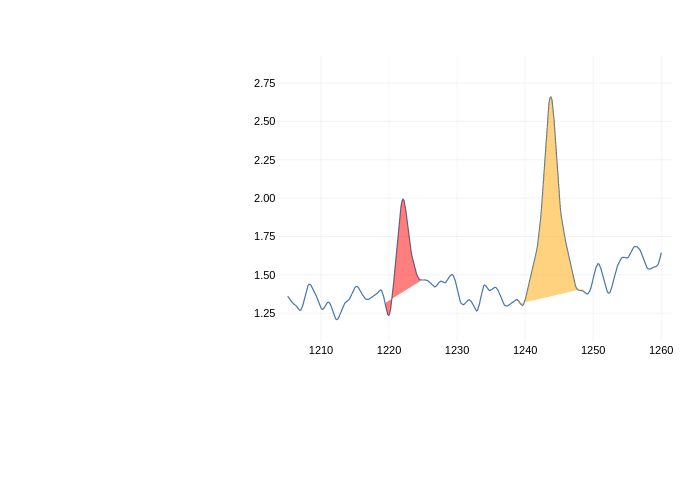

In [9]:
NoisySignalIntegration.animate_draws(unc_signal, [leftbnd, rightbnd]; local_baseline=true, size=(100, 50))

Integrate the signals:

In [10]:
L, R = mc_integrate(unc_signal, [leftbnd, rightbnd]; local_baseline=true)

2-element Vector{MonteCarloMeasurements.Particles{Float64, 10000}}:
 1.4 ± 0.17
 3.73 ± 0.27

Calculate further quantities, e.g. a ratio:

In [11]:
L/R

MonteCarloMeasurements.Particles{Float64, 10000}
 0.376944 ± 0.0533